In [3]:
import os
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import  CountVectorizer

from wordcloud import WordCloud

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');



/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/tonton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tonton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tonton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def text_edit(text):
    # remove first two lines
    text = '\n'.join(text.split('\n')[2:])

    # cut longer than 2000 characters
    text = text[:2000]

    # # remove everything After Kilde:
    # text = text.split('Kilde:')[0]

    # remove empty lines
    # text = '\n'.join([line for line in text.split('\n') if line != ''])

    # remove new lines
    # text = ' '.join(text.split('\n'))

    # remove double spaces
    # text = ' '.join(text.split('  '))

    # remove emojis
    # text = text.encode('ascii', 'ignore').decode('ascii')
   

    # Assuming 'text' is defined and contains sentences
    # sentences = text.split('.')
    # num_sentences = len(sentences)
    # if num_sentences > 4:

    #     # Create an exponential distribution for probabilities
    #     # The exponential distribution should favor lower indices for rand_low and higher indices for rand_high
    #     probabilities = np.exp(np.linspace(0, 2, num_sentences-1))
    #     probabilities /= probabilities.sum()  # Normalize to make it a valid probability distribution

    #     # Choose rand_low and rand_high using the defined probabilities
    #     rand_low = np.random.choice(np.arange(num_sentences-1), p=probabilities[::-1])
    #     rand_high = np.random.choice(np.arange(rand_low+1, num_sentences), 
    #                     p=probabilities[rand_low:] / probabilities[rand_low:].sum())

    #     # Join the selected range of sentences
    #     text = '.'.join(sentences[rand_low:rand_high])

    cuts = [text]
    # sentences = text.split('. ')
    # num_sentences = len(sentences)
    # # if we have for example 12 setences, we want to cut it into 3 pieces
    # num_cuts = num_sentences // 4

    # for i in range(num_cuts):
    #     cuts.append('. '.join(sentences[i*4:(i+1)*4]))
        

    return cuts

def load_data():

    import os

    data = {
        'human': [],
        'bot': []
    }

    data_sources = {
        'human' : ['data/heste-nettet-nyheder/', 
                   'data/from_big_data_file/'][::-1],
        'bot' : ['data/heste-nettet-nyheder-ai/gpt-3.5-turbo/', 
                'data/heste-nettet-nyheder-ai/gpt-4-0613/', 
                 'data/from_big_data_file_ai/gpt-3.5-turbo/',
                 'data/from_big_data_file_ai/gpt-3.5-turbo-0613/'][::-1]
    }

    for source in data_sources:
        for path in data_sources[source]:
            for filename in os.listdir(path):
                with open(path + filename, 'r', encoding='utf-8') as f:
                    content = f.read()
                    cuts = text_edit(content)
                    for text in cuts:
                        data[source].append(text)

    

    # cut to same length
    min_len = min(len(data['human']), len(data['bot']))
    data['human'] = data['human'][:min_len]
    data['bot'] = data['bot'][:min_len]
    
    # shuffle data
    np.random.shuffle(data['human'])
    np.random.shuffle(data['bot'])

    my_texts = np.array(data['human'] + data['bot'])
    my_labels = np.array([0]*len(data['human']) + [1]*len(data['bot'])) 

    return list(my_texts), my_labels

def get_sentence_data(df, inplace = True):
    """
    For each row in the dataframe, find the number of sentences,
    and the average and std number of words per sentence.
    """

    # Make a copy of the dataframe
    df = df.copy()

    # Get the number of sentences
    df['num_sentences'] = df['text'].apply(lambda x: len(x.split('.')))

    # Get the average number of words per sentence
    df['avg_words_per_sentence'] = df['text'].apply(lambda x: np.mean([len(sentence.split(' ')) for sentence in x.split('.')]))

    # Get the std number of words per sentence
    df['std_words_per_sentence'] = df['text'].apply(lambda x: np.std([len(sentence.split(' ')) for sentence in x.split('.')]))

    # Get the average number of words per sentence
    df['avg_words_per_sentence'] = df['text'].apply(lambda x: np.mean([len(sentence.split(' ')) for sentence in x.split('.')]))

    # Get the std number of words per sentence
    df['std_words_per_sentence'] = df['text'].apply(lambda x: np.std([len(sentence.split(' ')) for sentence in x.split('.')]))

    if inplace:
        return df
    else:
        return df[['num_sentences', 'avg_words_per_sentence', 'std_words_per_sentence']]

def analyze_sentences(df_text):
    """
    For each row in the dataframe, find the number of sentences,
    the average and std number of words per sentence, the average and std number of words between sentences,
    and the avg. no. of abbreviations and capital letters per sentence.

    
    Parameters
    ----------
    df_text: pd.DataFrame
        Dataframe containing the text column

    Returns
    -------
    sentence_count, mean_words_per_sentence, std_words_per_sentence, mean_diff_words, std_diff_words, avg_abbrev_per_sentence, \
        avg_capital_letters_per_sentence, avg_dash_quest_semicolon_per_sentence, double_quest_excl_count

    """

    sentences = nltk.tokenize.sent_tokenize(df_text)
    sentence_count = len(sentences)


    if sentence_count == 0:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    words_per_sentence = np.array([len(nltk.tokenize.word_tokenize(sentence)) for sentence in sentences])

    total_abbrev_count = 0
    total_capital_count = 0
    total_dash_quest_semicolon_count = 0
    total_double_quest_excl_count = 0
    total_excl_count = 0

    for sentence in sentences:
        # Count abbreviations using a simple regex pattern
        abbrev_count = len(re.findall(r'\b[A-Za-z]{2,}\.(?![a-z])', sentence))
        total_abbrev_count += abbrev_count
        
        # Count capital letters
        capital_count = sum(1 for c in sentence if c.isupper())
        total_capital_count += capital_count

        # Count dashes, question marks, and semicolons
        dash_quest_semicolon_count = sentence.count('-') + sentence.count('?') + sentence.count(';')
        total_dash_quest_semicolon_count += dash_quest_semicolon_count

        # Count double question marks and exclamation marks
        double_quest_excl_count = sentence.count('??') + sentence.count('!!') + sentence.count('?!') + sentence.count('!?')
        total_double_quest_excl_count += double_quest_excl_count

        # Count exclamation marks
        excl_count = sentence.count('!')
        total_excl_count += excl_count

    # Exclude ! from the count if it ends the last sentence or follows hej or spørgsmål
    last_sentence = sentences[-1]
    total_excl_count -= last_sentence.count('!')
    total_excl_count -= len(re.findall(r'\b(?:hej|spørgsmål)!', sentences[0]))




    if sentence_count > 1:
        # find mean and std for the length of consecutive sentences
        diff_words_between_sentences = np.diff(words_per_sentence)
        mean_diff_words = np.mean(diff_words_between_sentences)
        std_diff_words = np.std(diff_words_between_sentences)
    else:
        mean_diff_words = 0
        std_diff_words = 0
    

    avg_abbrev_per_sentence = total_abbrev_count / sentence_count
    avg_capital_letters_per_sentence = total_capital_count / sentence_count
    avg_dash_quest_semicolon_per_sentence = total_dash_quest_semicolon_count / sentence_count
    avg_excl_per_sentence = total_excl_count / sentence_count
 
    mean_words_per_sentence = np.mean(words_per_sentence)
    std_words_per_sentence = np.std(words_per_sentence)

    

    return sentence_count, mean_words_per_sentence, std_words_per_sentence, mean_diff_words, std_diff_words, avg_abbrev_per_sentence, \
        avg_capital_letters_per_sentence, avg_dash_quest_semicolon_per_sentence, total_double_quest_excl_count, avg_excl_per_sentence

def count_specific_words(text, word_lists):
    sentences = nltk.tokenize.sent_tokenize(text)
    sentence_count = len(sentences)
    
    # Initialize a list to store counts for each word list separately
    word_counts_per_list = [[] for _ in range(len(word_lists))]
    
    for sentence in sentences:
        for idx, word_list in enumerate(word_lists):
            # Initialize a counter for specified words in the current word list
            word_count = 0
            
            # Explicit variations of words in each word list to count
            for word in word_list:
                word_count += sentence.count(f'{word}')  # Space before and after
                word_count += sentence.count(f'{word.upper()}')
                # Add other variations as needed
            
            # Append the word count for the current word list
            word_counts_per_list[idx].append(word_count)
    
    # Calculate the average count per sentence for each word list
    avg_words_per_sentence = [sum(counts) / sentence_count if sentence_count > 0 else 0 for counts in word_counts_per_list]
    
    # return each value separately
    
    return avg_words_per_sentence

def word_lookup(data):

    plural_pronouns = [' vi ', ' os ', ' vores ']

    human_fillers = [' jo ', ' jo,' ' jo!', ' lige ', ' sådan noget',  ' bestemt ',  ' bestemt!',  ' bestemt,',  ' bestemt.', ' gerne ', ' gerne!', ' gerne,', ' gerne.', ' rigtig god']
    ai_fillers = [' samt ', ' dette ', ' mens ', ' dog ']
    ai_fillers2 = [' en vis ', ' sammenfattende ']
    woke_list = [' tilbøjelig ', ' tilbøjelige ', ' parter ', ' grupper ', ' organisationer ', ' organisationer.', ' føle sig ', ' føler sig ']
    fake_news_list = [' subjektiv ', ' kilder ', ' kilder.', ' studier ', ' forklaringer ',
    ' manipulation ', ' disinformation ', ' disinformation.', ' misinformation ', ' misinformation.' ' da det ',]
    ai_words1 = [' vigtigt, at', ' vigtigt at ']
    ai_words2 = [' svært at ']
    ai_words3 = ['Jeg er en AI', 'personlige meninger eller meninger']

    word_lists = [human_fillers, ai_fillers, ai_fillers2, woke_list, fake_news_list, ai_words1, ai_words2, ai_words3]
    column_names = ['human_fillers', 'ai_fillers', 'ai_fillers2', 'woke', 'fake_news', 'ai_words1', 'ai_words2', 'ai_words3']

    data[[col for col in column_names]] = data.apply(lambda row: count_specific_words(row['text'], word_lists), axis=1).apply(pd.Series)

    return data

    

In [20]:
text, labels = load_data()

data = pd.DataFrame({'text': text, 'label': labels})

print(data.head()), print(data.shape)

                                                text  label
0  I forbindelse med vores uddannelsestema, skal ...      0
1  Der bliver ikke noget Royal Ascot for Media Hy...      0
2    Blue Hors har gennem de seneste år investere...      0
3  Det må man sige, at Lis Lihme som holdleder fo...      0
4  Anky van Grunsven der ikke blot er kendt som d...      0
(23411, 2)


(None, None)

In [21]:
data[['sentence_count', 'mean_words_per_sentence', 'std_words_per_sentence', 'neighbor_sentences_diff', \
      'neighbor_sentences_diff_std', 'abbrev_per_sentence', 'captials_per_sentence', 'avg_dash_quest_semicolon_per_sentence', 'double_quest_excl_count', 'avg_excl_per_sentence']] = data['text'].apply(analyze_sentences).apply(pd.Series)

In [22]:
# Assuming 'count_specific_words' and 'word_lists' are defined as mentioned in the previous code snippet

# Apply count_specific_words along with additional arguments using lambda function
data = word_lookup(data)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23411 entries, 0 to 23410
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   text                                   23411 non-null  object 
 1   label                                  23411 non-null  int64  
 2   sentence_count                         23411 non-null  float64
 3   mean_words_per_sentence                23411 non-null  float64
 4   std_words_per_sentence                 23411 non-null  float64
 5   neighbor_sentences_diff                23411 non-null  float64
 6   neighbor_sentences_diff_std            23411 non-null  float64
 7   abbrev_per_sentence                    23411 non-null  float64
 8   captials_per_sentence                  23411 non-null  float64
 9   avg_dash_quest_semicolon_per_sentence  23411 non-null  float64
 10  double_quest_excl_count                23411 non-null  float64
 11  av

In [23]:
data.head(3)

,text,label,sentence_count,mean_words_per_sentence,std_words_per_sentence,neighbor_sentences_diff,neighbor_sentences_diff_std,abbrev_per_sentence,captials_per_sentence,avg_dash_quest_semicolon_per_sentence,double_quest_excl_count,avg_excl_per_sentence,human_fillers,ai_fillers,ai_fillers2,woke,fake_news,ai_words1,ai_words2,ai_words3
0,"I forbindelse med vores uddannelsestema, skal ...",0,4.0,19.750000,8.196798,-5.333333,8.178563,0.500000,2.250000,0.250000,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Der bliver ikke noget Royal Ascot for Media Hy...,0,11.0,22.636364,14.986495,0.800000,22.012724,0.545455,4.090909,0.000000,0.0,0.0,0.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Blue Hors har gennem de seneste år investere...,0,9.0,12.333333,13.605554,-5.250000,9.653367,0.777778,4.333333,0.111111,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# shuffle the dataframe
df = data.sample(frac=1, random_state=42).reset_index(drop=True)
features = df.drop(['label', 'text'], axis=1)
features
labels = df['label']

# apply standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)


In [25]:
# run xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

# fit model no training data
model = xgb.XGBClassifier(
    objective='binary:logistic',  # error evaluation for multiclass training
    eval_metric='logloss',  # evaluation metric, could also use: auc, error (https://xgboost.readthedocs.io/en/latest/parameter.html)
    use_label_encoder=False, # the XGBClassifier is set up for binary classification, so we need to disable the label encoder
    learning_rate=0.051, # step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features and eta shrinks the feature weights to make the boosting process more conservative.
    max_depth=50, # determines how deeply each tree is allowed to grow during any boosting round.
    n_estimators=500,  # number of trees you want to build.
    subsample=0.8,  # percentage of samples used per tree. Low value can lead to underfitting.
    colsample_bytree=0.3,  # percentage of features used per tree. High value can lead to overfitting.
    gamma=1,  # specifies the minimum loss reduction required to make a split.  Higher values lead to fewer splits.
    seed=42
)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy: %.2f%%" % (accuracy * 100.0))



Accuracy: 95.75%


## predictions on validation set

In [26]:
df_val = pd.read_csv('data/val.csv', index_col=0)
df_val.rename(columns={'0': 'text'}, inplace=True)

df_val[['sentence_count', 'mean_words_per_sentence', 'std_words_per_sentence', 'neighbor_sentences_diff', \
      'neighbor_sentences_diff_std', 'abbrev_per_sentence', 'captials_per_sentence', 'avg_dash_quest_semicolon_per_sentence', 'double_quest_excl_count', 'avg_excl_per_sentence']] = df_val['text'].apply(analyze_sentences).apply(pd.Series)

df_val = word_lookup(df_val)

df_val.head(3)

,text,sentence_count,mean_words_per_sentence,std_words_per_sentence,neighbor_sentences_diff,neighbor_sentences_diff_std,abbrev_per_sentence,captials_per_sentence,avg_dash_quest_semicolon_per_sentence,double_quest_excl_count,avg_excl_per_sentence,human_fillers,ai_fillers,ai_fillers2,woke,fake_news,ai_words1,ai_words2,ai_words3
0,"I min optik er god forskning det samme som ""st...",4.0,19.50,5.024938,4.333333,6.798693,0.50,1.0,0.25,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Jeg synes, der er rigtig gode erstatninger på ...",2.0,25.00,13.000000,26.000000,0.000000,1.00,4.5,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Selvom der er tale om en sag, der har været i ...",4.0,26.75,7.428829,-6.666667,5.436502,0.75,1.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# predict on validation set
features_val = df_val.drop(['text'], axis=1)

scaled_features_val = scaler.transform(features_val)
y_pred_val = model.predict(scaled_features_val)

sum(y_pred_val), len(y_pred_val)

(313, 1133)

In [28]:
np.savez('xgboost_pred.npz', pred=y_pred_val)

## compare val set and train set

In [29]:
# import tsne
from sklearn.manifold import TSNE

# create tsne object
tsne = TSNE(n_components=2, random_state=42).fit(features)

# transform features and features_val
features_tsne = tsne.fit_transform(scaled_features)
features_val_tsne = tsne.fit_transform(scaled_features_val)



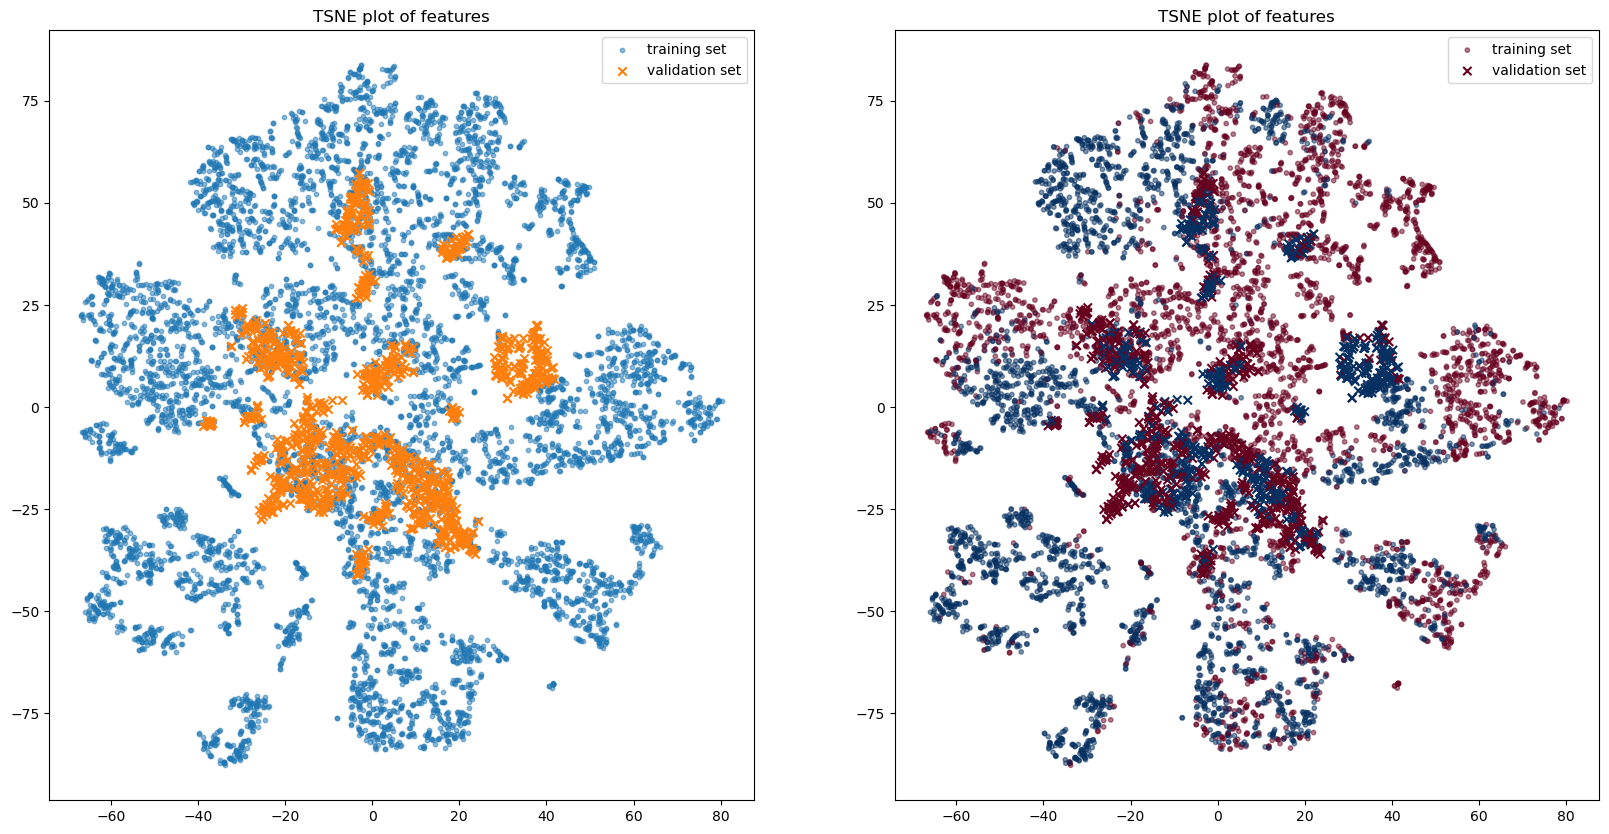

In [ ]:
select_box = np.array([
    [-37,20],
    [-50,20]
])

# plot
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(features_tsne[:, 0], features_tsne[:, 1], 
            # c=labels, 
            # cmap='Grays', 
            s=10, alpha=0.5, label='training set')
ax[0].scatter(features_val_tsne[:, 0], features_val_tsne[:, 1], 
            # c=y_pred_val, cmap='RdBu', 
            marker='x', alpha=1, label='validation set')
ax[0].set_title('TSNE plot of features')

ax[0].legend()


ax[1].scatter(features_tsne[:, 0], features_tsne[:, 1], 
            c=labels, 
            cmap='RdBu', 
            s=10, alpha=0.5, label='training set')
ax[1].scatter(features_val_tsne[:, 0], features_val_tsne[:, 1], 
            c=y_pred_val, cmap='RdBu', 
            marker='x', alpha=1, label='validation set')
ax[1].set_title('TSNE plot of features')

ax[1].legend()

# plot select box
# plt.fill_betweenx(select_box[:, 0], select_box[:, 1], color='red', alpha=0.1)
# background black

plt.show()

In [ ]:
# print sentences in select box
for i, (x, y) in enumerate(features_val_tsne):
    if select_box[0, 0] < y < select_box[0, 1] and select_box[1, 0] < x < select_box[1, 1]:
        print(f"{i}: {df_val['text'][i]}")

0: I min optik er god forskning det samme som "struktureret kreativitet". Så intuition er bestemt en god ting at have med sig - udover at man selvfølgelig skal kunne nogle forskningsteknikker. Men forskningsteknikkerne kan man lære, det er tilgengæld ikke som nemt at lære intuition. Så hvis du er en person, der er god til intuition, så er du allerede godt på vej til at blive "god".
2: Selvom der er tale om en sag, der har været i retssystemet i flere år, og som har haft en lang og omfattende behandling, så er dommen ikke blevet ud til læsning for almindeligt dødelige.

Retten har ikke truffet denne dom endnu, og det er ikke almindeligt, at domme bliver ud til læsning før de er truffet. Det er normalt, at domme først bliver ud til læsning efter at have været truffet, så de kan læses af offentligheden.

Men hvis vi ser på, hvor dommen denne gang er, så er den endnu ikke truffet.
4: Ja! Det er helt horribelt at der fortsat sidder danske børn i de lejre. Uanset at deres mødre ikke er dansk

## Compare distribuion of features in train and test set

In [ ]:
len(df.columns[2:])

18

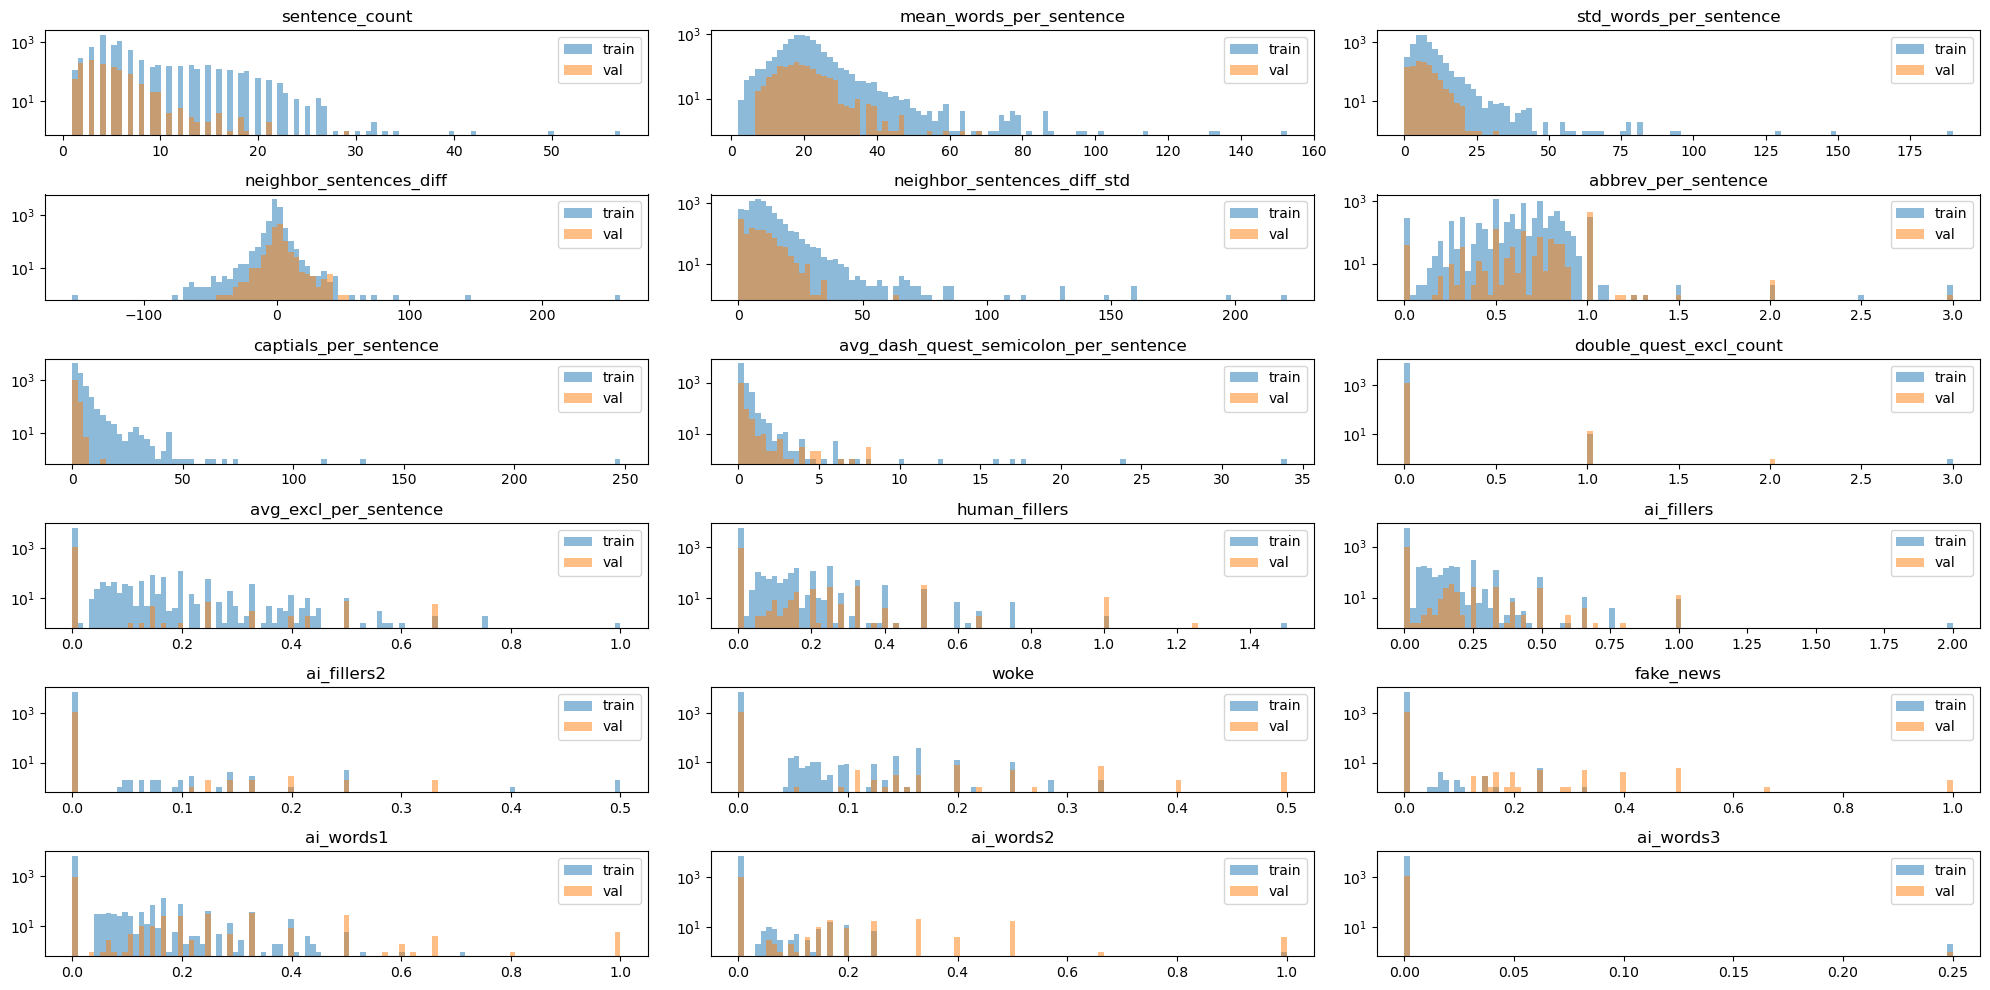

In [ ]:
fig, axes = plt.subplots(6,3,figsize=(20,10))

for col, ax in zip(df.columns[2:], axes.flatten()):

    data_train_0 =  df[col]
    # data_train_1 =  df[df['label'] == 1][col]

    data_val_0 =  df_val[col]
    # data_val_1 =  df_val[df_val['label'] == 1][col]

    # define shared bins
    bins = np.linspace(min(data_train_0.min(), data_val_0.min()), max(data_train_0.max(), data_val_0.max()), 100)
    
    # plot histograms
    ax.hist(data_train_0, bins=bins, alpha=0.5, label='train')
    ax.hist(data_val_0, bins=bins, alpha=0.5, label='val')
    ax.set_title(col)
    ax.legend()
    ax.set_yscale('log')

plt.tight_layout()
